<a href="https://colab.research.google.com/github/EduardoLawson1/Pytorch-Practice/blob/main/Pytorch%20Model%20Deployment%20/Pytorch_Model_Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09. Pytorch Model Deployment

Machine model deployment is the act of making your machine learning model(s) available to someone or something else



## 0. Get setup

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.7.1+cu126
torchvision version: 0.22.1+cu126


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 43.21 MiB/s, done.
Resolving deltas: 100% (2657/2657), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Geting data
We will work with Food data 101


In [4]:
## 1. Getting data - food 101 dataset
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [5]:
# Setup training and test paths
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### 3. Creating a EffNetB2 feature extractor


In [6]:
import torchvision

# 1.Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get the transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3 Setup pre trained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights="DEFAULT")

# 4. Freezte the base layers in the model
for param in effnetb2.parameters():
  param.requires_grad=False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:00<00:00, 70.6MB/s]


In [7]:
from torchinfo import summary
summary(effnetb2,
        input_size=[1, 3, 224, 224],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [8]:
# Set seeds for reproducibility
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
)

In [9]:
from torchinfo import summary
summary(effnetb2,
        input_size=[1, 3, 224, 224],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.1 Creating a function to make an EffNetB2 feature extractor

In [10]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
  # 1, 2, 3 Create EffnetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. Freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.03, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes)
  )
  return model, transforms

In [11]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [12]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### 3.2 Creating DataLoaders for Effnetb2

In [13]:
# Setup DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [14]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 3.3 Training EffNetB2 feature extractor

In [15]:
from going_modular.going_modular import engine

# Loss function
loss_fn = nn.CrossEntropyLoss()

#optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

## Training function

set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device
                              )

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9522 | train_acc: 0.6188 | test_loss: 0.7062 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.6762 | train_acc: 0.8667 | test_loss: 0.5492 | test_acc: 0.9534
Epoch: 3 | train_loss: 0.5446 | train_acc: 0.8771 | test_loss: 0.4534 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4145 | train_acc: 0.9229 | test_loss: 0.4022 | test_acc: 0.9437
Epoch: 5 | train_loss: 0.3910 | train_acc: 0.9083 | test_loss: 0.3620 | test_acc: 0.9534
Epoch: 6 | train_loss: 0.3895 | train_acc: 0.8958 | test_loss: 0.3239 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.3925 | train_acc: 0.8833 | test_loss: 0.3017 | test_acc: 0.9625
Epoch: 8 | train_loss: 0.3746 | train_acc: 0.9000 | test_loss: 0.3224 | test_acc: 0.9381
Epoch: 9 | train_loss: 0.3586 | train_acc: 0.9000 | test_loss: 0.2912 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3311 | train_acc: 0.8729 | test_loss: 0.2612 | test_acc: 0.9563


### 3.4 Inspecting EffNetB2 loss curves

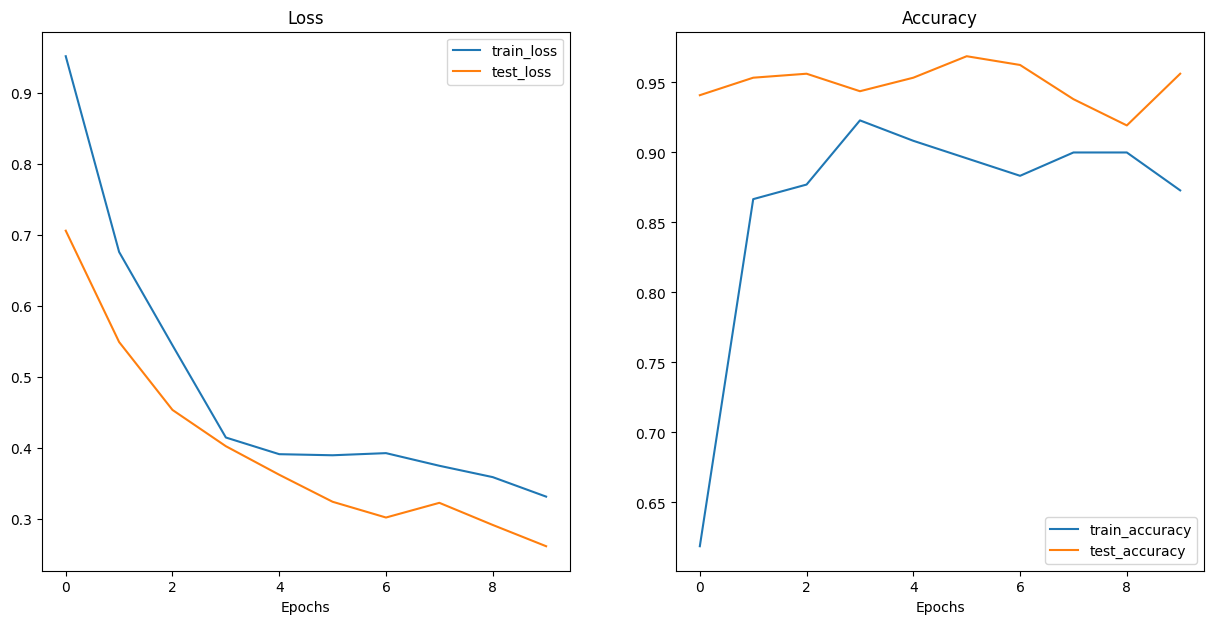

In [16]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

### 3.5 Saving EffNetB2 feature eztractor

In [17]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Inspecting the size of our EffNetB2 feature extractor

In [18]:
from pathlib import Path

# Get the model size in bytes and convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained EffNetB2 featre extactor model size: {round(pretrained_effnetb2_model_size, 2)} MB")

Pretrained EffNetB2 featre extactor model size: 29.86 MB


### 3.7 Collecting EffNetB2 feature extractor stats

In [19]:
# Count number of parameters in EffnetaB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [20]:
# Create a dictionary with effnetb2 stats
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.2611818194389343,
 'test_acc': 0.95625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.86450481414795}

## 4. Creating a ViT feature extractor

In [21]:
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [22]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes

    return model, transforms


In [23]:
vit, vit_transforms = create_vit_model()
vit_transforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:03<00:00, 90.2MB/s]


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [24]:
from torchinfo import summary
summary(vit,
        input_size=[1, 3, 224, 224],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 4.1 Create DataLoaders for ViT feature extractor

In [25]:
# Setuo Vit DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)
len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.2 Traning Vit Feature Extractor

In [26]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train vit feature extractor with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)
vit_results

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


{'train_loss': [0.7019952992598216,
  0.25320701897144315,
  0.17639242460330326,
  0.1276150168851018,
  0.11590948204199474,
  0.12736559386054674,
  0.08970987955108285,
  0.09194954906900724,
  0.092181725303332,
  0.06576695380111536],
 'train_acc': [0.7520833333333333,
  0.90625,
  0.9541666666666667,
  0.9625,
  0.9645833333333333,
  0.9375,
  0.9770833333333333,
  0.98125,
  0.9791666666666666,
  0.9833333333333333],
 'test_loss': [0.2713926836848259,
  0.16721019074320792,
  0.12734055388718843,
  0.10736146979033948,
  0.09531822912395001,
  0.08322930112481117,
  0.08448823317885398,
  0.07639321740716695,
  0.07343243481591344,
  0.06443451717495918],
 'test_acc': [0.9380681818181819,
  0.9602272727272727,
  0.9693181818181819,
  0.972159090909091,
  0.978409090909091,
  0.972159090909091,
  0.978409090909091,
  0.972159090909091,
  0.978409090909091,
  0.984659090909091]}

### 4.3 Plot loss curves of ViT feature extractor

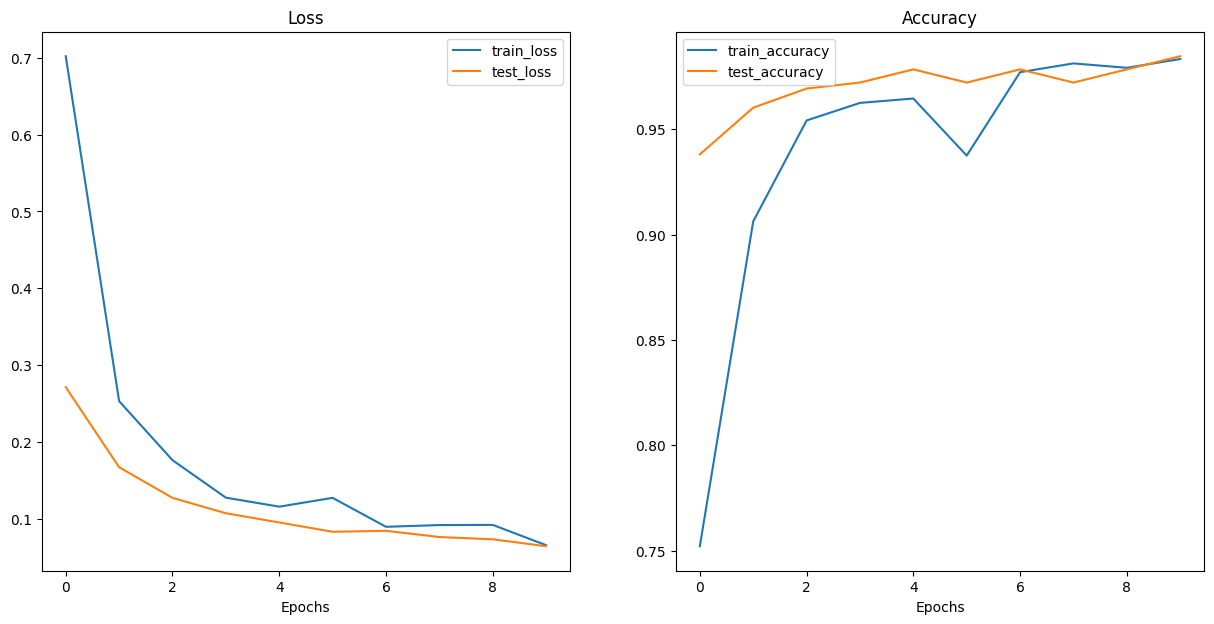

In [27]:
plot_loss_curves(vit_results)

### 4.4  Saving ViT feature extractor

In [28]:
# Save model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="pre_trained_vit_feature_extractor.pth")


[INFO] Saving model to: models/pre_trained_vit_feature_extractor.pth


### 4.5 Checking the size of ViT feature extractor

In [29]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/pre_trained_vit_feature_extractor.pth").stat().st_size / (1024*1024)
print(f"Pretrained ViT Feature Extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT Feature Extractor model size: 327.36660289764404 MB


### 4.6 Collecting ViT feature extractor stats

In [30]:
# Count number of parameters in VIT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [31]:
effnetb2_total_params

7705221

In [32]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}


In [33]:
vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.36660289764404}

## 5. Making predictions with our trained models and timing

In [34]:
from pathlib import Path

# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/511818.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/3494950.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/804460.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/167716.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/46797.jpg')]

### 5.1 Creating a function to make across the test dataset

1. Creates a function that takes a list of paths and a trained PyTorch and a series
of transforms a list of target class names and a target device.
2. Creates an empty list (can return a full list of all predictions later)
3. Loop through the target input paths (the rest of the steps will take place inside the loop).
4. Create an empty dictionary for each sample (prediction statistics will go in here).
5. Get the sample path and ground truth class from the filepath
6. Start the prediction timer
7. Open the image using `PIL.Image.open(path)`.
8. Transform the image to be usable with a given model.
9. Prepare the model for inference by sending to the target device and turning on `eval()` mode.
10. Turn on `torch.inference_mode()` and pass the target transformed image to the model an perform
foward pass + calculate pred prob + pred class
11. Add the pred prob + pred class to empty dictionary from step 4
12. End the prediction timer started in step 6 and add the time to the prediction dictionary.
13. See if the precicted class matches the ground truth class.
14. Append the updated prediction dictionary to the empty list of predictions we created in step 2.
15. Return the list of predicition dictionaries

In [35]:
import pathlib
from PIL import Image
import torch
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

#1. Creates a function that takes a list of paths and a trained PyTorch and a series of transforms a list of target class names and a target device.
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

  # 2. Creates an empty list (can return a full list of all predictions later)
  pred_list = []

  # 3. Loop through the target input paths (the rest of the steps will take place inside the loop).
  for path in tqdm(paths):

    # 4. Create an empty dictionary for each sample (prediction statistics will go in here).
    pred_dict = {}

    # 5. Get the sample path and ground truth class from the filepath
    pred_dict["image_path"] = path
    class_name = path.parent.stem # Takes the last folder name
    pred_dict["class_names"] = class_name

    # 6. Start the prediction timer
    start_timer = timer()

    # 7. Open the image using `PIL.Image.open(path)`.
    img = Image.open(path)

    # 8. Transform the image to be usabel with a given model
    transformed_image = transform(img).unsqueeze(0).to(device)

    # 9. Prepare the model for inference by sending to the target device and turning on `eval()` mode.
    model = model.to(device)
    model.eval()

    # 10. Turn on `torch.inference_mode()` and pass the target transformed image to the model an perform foward pass + calculate pred prob + pred class
    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim=1) # turn raw logits into pred probs
      pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into labels
      pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU (PYTHON variables never go to GPU)

      # 11. Add the pred prob + pred class to empty dictionary from step 4
      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict["pred_class"] = pred_class

      # 12. End the prediction timer
      end_time = timer()
      pred_dict["time_for_pred"] = round(end_time-start_timer)

    # 13. See if the precicted class matches the ground truth class./
    pred_dict["correct"] = class_name == pred_class

    # 14. Append the updated prediction dictionary to the empty list of predictions we created in step 2.]
    pred_list.append(pred_dict)

  # 15. Return the list of predicition dictionaries
  return pred_list




### 5.2 Making ant timing predictions with EffNetB2

In [36]:
# Make predictions test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [37]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/511818.jpg'),
  'class_names': 'sushi',
  'pred_prob': 0.6607,
  'pred_class': 'sushi',
  'time_for_pred': 0,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/3494950.jpg'),
  'class_names': 'sushi',
  'pred_prob': 0.6563,
  'pred_class': 'sushi',
  'time_for_pred': 0,
  'correct': True}]

In [38]:
# Turn into a dataframe
import pandas as pd

effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_names,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/5...,sushi,0.6607,sushi,0,True
1,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.6563,sushi,0,True
2,data/pizza_steak_sushi_20_percent/test/sushi/8...,sushi,0.5576,sushi,0,True
3,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.5231,sushi,0,True
4,data/pizza_steak_sushi_20_percent/test/sushi/4...,sushi,0.9342,sushi,0,True


In [40]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

,count
correct,
True,143
False,7


In [42]:
# Find the average time per prediction
effnetb2_average_time_per_pred = effnetb2_test_pred_df.time_for_pred.mean()
print(f"EffNetB2 average time per predicion: {effnetb2_average_time_per_pred}")

EffNetB2 average time per predicion: 0.0


In [51]:
# Add time per pred to EffNetB2 stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.2611818194389343,
 'test_acc': 0.95625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.86450481414795,
 'time_per_pred_cpu': np.float64(0.0)}

### 5.3 Making and timing predictions with ViT


In [44]:
# Make list of prediction dictionaries with ViT model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [46]:
# Check the firs couple of vit predictions
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/511818.jpg'),
  'class_names': 'sushi',
  'pred_prob': 0.9895,
  'pred_class': 'sushi',
  'time_for_pred': 1,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/3494950.jpg'),
  'class_names': 'sushi',
  'pred_prob': 0.9657,
  'pred_class': 'sushi',
  'time_for_pred': 1,
  'correct': True}]

In [47]:
# Turn into a dataframe
import pandas as pd

vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_names,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/5...,sushi,0.9895,sushi,1,True
1,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.9657,sushi,1,True
2,data/pizza_steak_sushi_20_percent/test/sushi/8...,sushi,0.9779,sushi,1,True
3,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.6123,sushi,1,True
4,data/pizza_steak_sushi_20_percent/test/sushi/4...,sushi,0.9923,sushi,1,True


In [48]:
# See how many correct
vit_test_pred_df.correct.value_counts()

,count
correct,
True,148
False,2


In [50]:
# Calculate average time per prediction for vit model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(),4)
print(f"ViT average time per predicion: {vit_average_time_per_pred}")

ViT average time per predicion: 1.02


In [52]:
# Add average time per prediction to ViT stats
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.36660289764404,
 'time_per_pred_cpu': np.float64(1.02)}

## 6. Comparing model results, prediction times and size

In [55]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["models"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] *100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,models
0,0.261182,95.62,7705221,29.864505,0.00,EffNetB2
1,0.064435,98.47,85800963,327.366603,1.02,ViT


In [58]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("models").loc["ViT"] / df.set_index("models").loc["EffNetB2"]),
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.246704,1.029805,11.135432,10.961729,inf
